# Import libraries

In [226]:
# Data manipulation
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets
import tensorflow_datasets as tfds

# Modeling
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, AvgPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data

### Load Dataset and get training, validation, and test sets

In [227]:
# Load MNIST dataset
ds, ds_info = tfds.load('mnist', shuffle_files=True, with_info=True)

# Convert to pandas dataframe and split into training, validation, and test sets
df_train, df_val = train_test_split(tfds.as_dataframe(ds['train'], ds_info), test_size=0.1, shuffle=False)
df_test = tfds.as_dataframe(ds['test'], ds_info)

# Print dataset info
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/keneth4/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

### Tensors and labels

In [228]:
# Create tensors for training, validation, and test sets
train = df_train['image'].apply(lambda x: x / 255).values.tolist()
val = df_val['image'].apply(lambda x: x / 255).values.tolist()
test = df_test['image'].apply(lambda x: x / 255).values.tolist()

# Create labels for training, validation, and test sets
train_labels = df_train['label'].values.tolist()
val_labels = df_val['label'].values.tolist()
test_labels = df_test['label'].values.tolist()

### Plot data examples

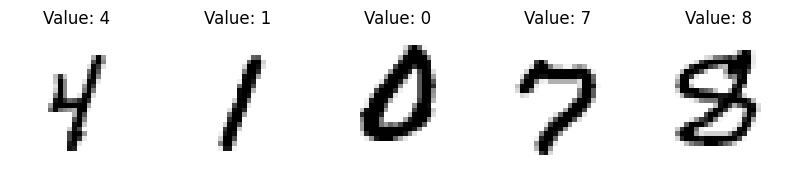

(28, 28, 1)    54000
Name: image, dtype: int64

In [229]:
# Plot the first 5 images in the training set
plt.figure(figsize=(10, 5))
for i, example in df_train.head().iterrows():
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(example['image'], cmap=plt.cm.binary)
    plt.title(f"Value: {example['label']}")
    plt.axis("off")
plt.show()

# Print image size
df_train['image'].apply(lambda x: x.shape).value_counts()

# Modeling

### Feature Extraction Layer

In [230]:
class FeatureExtractor(Layer):
    """Feature extractor Layer"""
    def __init__(
            self,
            filters: int,
            kernel_size: int,
            strides: int,
            padding: str,
            activation: str,
            pool_size: int,
        ) -> None:
        super().__init__()

        self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch1 = BatchNormalization() # Added batch normalization
        self.avgpool1 = AvgPool2D(pool_size = pool_size, strides= 2*strides)

        self.conv2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch2 = BatchNormalization() # Added batch normalization
        self.avgpool2 = AvgPool2D(pool_size = pool_size, strides= 2*strides)

    def call(self, x):

        x = self.conv1(x)
        x = self.batch1(x)
        x = self.avgpool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.avgpool2(x)

        return x

### LeNet-5 Model using Feature Extraction Layer

In [231]:
class LeNet5(Model):
    """LeNet5 model"""
    def __init__(self, num_classes: int) -> None:
        super().__init__()

        self.feature_extractor = FeatureExtractor(
            filters = 6,
            kernel_size = 5,
            strides = 1,
            padding = 'same',
            activation = 'tanh',
            pool_size = 2
        )

        # Classifier
        self.flatten = Flatten()
        self.dense1 = Dense(units=120, activation='relu')
        self.dense2 = Dense(units=84, activation='relu')
        self.dense3 = Dense(units=num_classes, activation='softmax')

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Training

In [232]:
# Create instance of LeNet5 model and print summary
lenet_5 = LeNet5(num_classes=10)
lenet_5(train[0].reshape(1, 28, 28, 1))
lenet_5.summary()

Model: "le_net5_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_12 (Feat  multiple                  2040      
 ureExtractor)                                                   
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 dense_30 (Dense)            multiple                  70680     
                                                                 
 dense_31 (Dense)            multiple                  10164     
                                                                 
 dense_32 (Dense)            multiple                  850       
                                                                 
Total params: 83734 (327.09 KB)
Trainable params: 83698 (326.95 KB)
Non-trainable params: 36 (144.00 Byte)
_______________

In [233]:
# Compile model
lenet_5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [234]:
# Train model
history = lenet_5.fit(
    np.array(train).reshape(-1, 28, 28, 1),
    np.array(train_labels),
    epochs=50,
    batch_size=32,
    validation_data=(np.array(val).reshape(-1, 28, 28, 1), np.array(val_labels)),
    verbose=1,
    steps_per_epoch=200,
    shuffle=True
)

Epoch 1/50
200/200 [==============================] - 3s 12ms/step - loss: 0.4440 - accuracy: 0.8644 - val_loss: 0.6113 - val_accuracy: 0.8062
Epoch 2/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1927 - accuracy: 0.9384 - val_loss: 0.2319 - val_accuracy: 0.9335
Epoch 3/50
200/200 [==============================] - 3s 14ms/step - loss: 0.1650 - accuracy: 0.9491 - val_loss: 0.1474 - val_accuracy: 0.9557
Epoch 4/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1358 - accuracy: 0.9567 - val_loss: 0.1452 - val_accuracy: 0.9545
Epoch 5/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1319 - accuracy: 0.9591 - val_loss: 0.1138 - val_accuracy: 0.9647
Epoch 6/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1164 - accuracy: 0.9648 - val_loss: 0.1011 - val_accuracy: 0.9695
Epoch 7/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1225 - accuracy: 0.9636 - val_loss: 0.1021 - val_accuracy: 0.9680

# Results

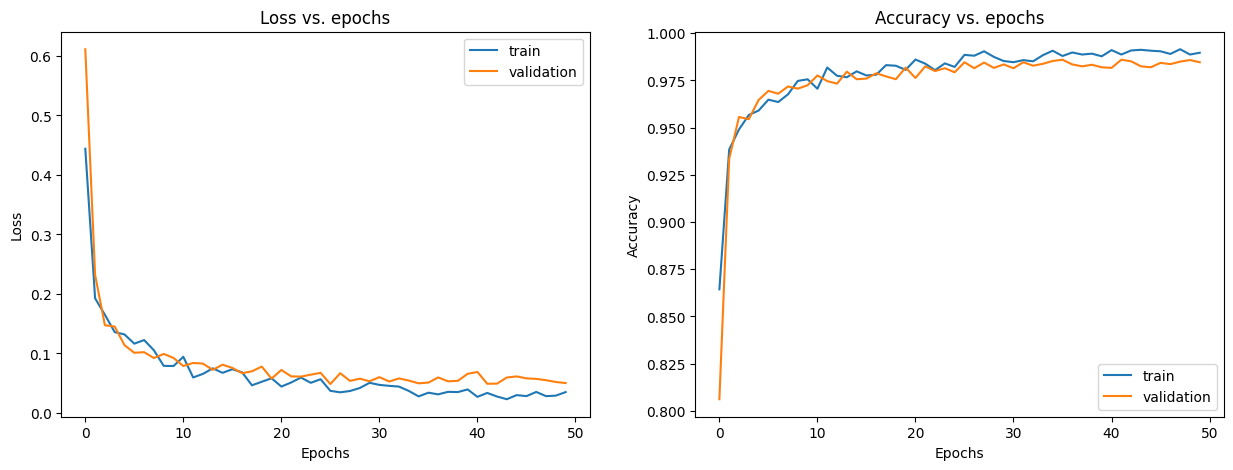

In [235]:
# Make two plots: loss vs. epochs and accuracy vs. epochs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


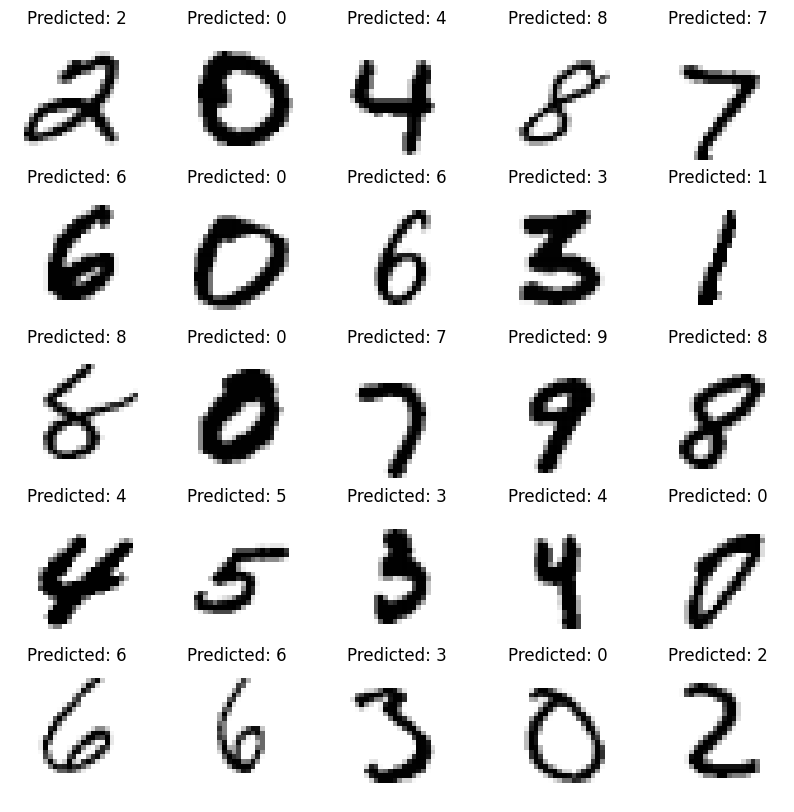

In [236]:
# Make predictions on test set
predictions = lenet_5.predict(np.array(test).reshape(-1, 28, 28, 1))

# Plot a matrix of 5x5 images in the test set with their predicted labels
plt.figure(figsize=(10, 10))
for i, example in df_test.head(25).iterrows():
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(example['image'], cmap=plt.cm.binary)
    plt.title(f"Predicted: {np.argmax(predictions[i])}")
    plt.axis("off")
plt.show()

# Save model

In [237]:
# Save model
lenet_5.save('mnist_lenet_5', save_format='tf')

# Load model
lenet_5 = tf.keras.models.load_model('mnist_lenet_5')

# Evaluate model on test set
lenet_5.evaluate(np.array(test).reshape(-1, 28, 28, 1), np.array(test_labels))

INFO:tensorflow:Assets written to: mnist_lenet_5/assets


INFO:tensorflow:Assets written to: mnist_lenet_5/assets


313/313 [==============================] - 1s 3ms/step - loss: 0.0541 - accuracy: 0.9842


[0.05406154692173004, 0.9842000007629395]